#**HW1-FRA503 Machine Learning**

#**Linear regression model**

---



In [ ]:
import os
import numpy as np
import pandas as pd
import numpy as np

- อ่านค่าจาก xlsx file ในชีทที่ชื่อ result_constituencies_status และทำการแสดงค่า attribute คร่าวๆ

In [ ]:
df = pd.read_excel('ML Dataset - ECT report 66.xlsx', sheet_name='result_constituencies_status')
df.head

FileNotFoundError: ignored

- จาก Dataset ได้เจาะจงชุดข้อมูลที่น่าสนใจคือ Result constituencies status ที่บอกถึงผลลัพธ์ของการมาใช้สิทธิ์และจำนวนหน่วยเลือกตั้งตามเขตต่างๆ โดยข้อมูลจะมีทั้งหมด 7 attributes ใน Sheet
- จะเห็นได้ว่าข้อมูลทั้งหมด 400 ตัวอย่างไม่มีการขาดหาย หรือ ตกหล่น ซึ่งสามารถนำไปใช้ได้เลย แต่จะมีข้อมูลบางอันที่มีค่าค่อนข้างเป็น Outlier หรือ มีตัวอย่างน้อยเกินไป ซึ่งไม่เหมาะสมที่จะนำมาใช้งาน เช่น percent_count คือจำนวนคะแนนเสียงที่นับแล้วต่ำเกินไป หรือ pause_report ที่ดูไม่เกี่ยวข้อและส่งผลกับข้อมูลอื่นๆ



###**2. Data Preprocessing**

- ทำการใส่ Column ที่แสดงถึงจำนวนเสียงที่มีสิทธิ์โหวตทั้งหมด ซึ่งคำนวนจากเปอร์เซ็นต์ผู้มาโหวต และ จำนวนผู้มาโหวตโดยชื่อว่า Total registered vote ซึ่งมีค่าเท่ากับข้อมูล total_registered_vote ในชีท info_province และปริ้นค่าออกมา

In [ ]:
df['total_registered_vote'] = df['turn_out']*100 / df['percent_turn_out']
df['total_registered_vote'] = df['total_registered_vote'].round(0)
df.head

- จากการตรวจสอบข้อมูล หลายๆสถานีนับจะมีปัญหาทำให้นับได้ไม่ครบทั้งหมด จึงทำการกรองข้อมูลสถานีนับที่มีการนับไม่ถึง 98% ของทั้งหมดเพื่อลดการกระโดดของข้อมูลที่อาจส่งผลต่อโมเดลได้ และเนื่องจากการหยุดนับนั้นไม่มีผลต่อโอกาสมาใช้สิทธิ์อย่างเห็นได้ชัด จึงตัดออกไปด้วย

In [ ]:
df.drop('pause_report',axis = 1,inplace = True)
df = df[df['percent_count'] > 98]

In [ ]:
df.describe()

- ทำการพิจาณาข้อมูล ซึ่งพบว่าจะมีตัวอย่างหลังจากถูกกรองออกเหลือ 393 ข้อมูล ส่วนมากไม่ได้มีการแปรผันมากมายจากค่า STD มาก  แต่ข้อมูลที่แตกต่างกันมากคือจำนวนคนในแต่ละเขต ซึ่งส่งผลกับจำนวนผู้มาใช้เสียง
-  ตัด Feature ที่จะไม่ถูกใช้ออก คือ
    - จำนวนคะแนนเสียงที่นับแล้ว เพราะได้กรองนับแล้วต่ำกว่า 98% ออกไปแล้ว
    - รหัสเขตเลือกตั้ง เพราะไม่ได้พิจารณาจำแนกความสัมพันธ์ของเขต

  จากนั้นพล็อตกราฟเพื่อดูความสัมพันธ์ของข้อมูล

In [ ]:
df.drop('percent_count',axis = 1,inplace = True)
df.drop('prov_id',axis = 1,inplace = True)

In [ ]:
import seaborn as sns
g = sns.pairplot(df)
g.fig.set_size_inches(8,8)

In [ ]:
print('Correlations')
print('\ntotal registred vote and counted vote stations')
print(df['total_registered_vote'].corr(df['counted_vote_stations']))
print('\npercent turn out and counted vote stations')
print(df['percent_turn_out'].corr(df['counted_vote_stations']))
print('\npercent turn out and total registered vote')
print(df['percent_turn_out'].corr(df['total_registered_vote']))

print('\nturn out and total registered vote')
print(df['turn_out'].corr(df['total_registered_vote']))
print('\nturn out and counted vote stations')
print(df['turn_out'].corr(df['counted_vote_stations']))
print('\nturn out and percent turn out')
print(df['turn_out'].corr(df['percent_turn_out']))

จากกราฟและค่า Correlation ของข้อมูล จะพบว่า
- จำนวนผู้มีสิทธิ์โหวตมาก จะส่งผลให้มีสถานีเลือกตั้งมากขึ้น แต่ไม่ส่งผลมาก
- จำนวนผู้มีสิทธิ์โหวตมาก ก็ส่งผลต่อเปอร์เซ็นต์ผู้มาโหวตมากเช่นกัน แต่ขึ้นอยู่กับผู้มีสิทธิ์โหวตทั้งหมดในแต่ละเขตด้วย
- ถ้ามีคนในเขตเลือกตั้งมาก คนก็จะมาโหวตเลือกตั้งมากเช่นกัน

###**3. Model Construction and Analysis**

###**- Linear regression Model:**
<B>สมมติฐาน : เราจะสามารถทำนายจำนวนผู้มาใช้สิทธ์ได้จากการจำนวนหน่วยเลือกตั้งทั้งหมด</B>

<B>การทดลองที่จัดให้ต่างกัน: ทำนายเป็นเปอร์เซ็น กับ ทำนายเป็นจำนวนคน</B>

<B>การ Preprocess ที่จัดให้ต่างกัน: Normalize กับ ไม่ Normalize</B>

    สร้าง dataframe แยกออกเป็น 2 การทดลอง

In [ ]:
#import machine learning library (Linear regression model)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
df1 = df
df2 = df

การทดลองที่ 1 : ทำนายเปอร์เซ็นต์ของผู้มาใช้สิทธิ์ จาก สถานีโหวต และ จำนวนผู้มีสิทธิ์โหวตทั้งหมด
- ทำการแบ่งชุดข้อมูล Test ออกไป 20% และเลือกเทรนด้วย total_registered_vote"กับ "counted_vote_stations" เพื่อให้ Output ออกมาเป็นเปอร์เซ็นต์ผู้มาใช้สิทธิ์โหวต

In [ ]:
#First assumption
x1 = df1[["total_registered_vote","counted_vote_stations"]].values
y1 = df1.percent_turn_out.values.reshape(-1,1)

x1_train,x1_test,y1_train,y1_test = train_test_split(x1,y1,test_size = 0.2,random_state = 42)

In [ ]:
#Build linear regression model
model_MultiLinear = LinearRegression()
model_MultiLinear.fit(x1_train,y1_train)

#y = theta0 + theta1*x1 +theta2*x2
print("Theta0: ",model_MultiLinear.intercept_[0])
print("Theta1: ",model_MultiLinear.coef_[0][0])
print("Theta2: ",model_MultiLinear.coef_[0][1])
print("y = {:.4f}+{:.4f}x1+{:.4f}x2".format(model_MultiLinear.intercept_[0],model_MultiLinear.coef_[0][0],model_MultiLinear.coef_[0][1]))

In [ ]:
#Predict on trainig set
y_pred = model_MultiLinear.predict(x1_train)

In [ ]:
# Model measurement on trainig dataset
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print("MAE = ",round(metrics.mean_absolute_error(y1_train,y_pred),4))
print("MAPE = ",round(MAPE(y1_train,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y1_train,y_pred)),4))

#mean square error
#root mean square error
#mean absolute percentage error
#R-Square

In [ ]:
#Predict on testing set
y_pred = model_MultiLinear.predict(x1_test)

In [ ]:
print("MAE = ",round(metrics.mean_absolute_error(y1_test,y_pred),4))
print("MAPE = ",round(MAPE(y1_test,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y1_test,y_pred)),4))

เทียบความต่างระหว่าง Normalized กับ ไม่ Normalized ของการทดลองที่ 1

    ทำการ Scale ข้อมูล Feature ให้เป็นช่วง 0 - 1

In [ ]:
#Doing normalization
df1['total_registered_vote'] = (df1['total_registered_vote']- df1['total_registered_vote'].min())/(df1['total_registered_vote'].max()-df1['total_registered_vote'].min())
df1['counted_vote_stations'] = (df1['counted_vote_stations']- df1['counted_vote_stations'].min())/(df1['counted_vote_stations'].max()-df1['counted_vote_stations'].min())


In [ ]:
#First assumption
x1_Normalized = df1[["total_registered_vote","counted_vote_stations"]]
y1_Normalized = df1.percent_turn_out.values.reshape(-1,1)
# y1 = df1.percent_turn_out.values.reshape(-1,1)

#Data preparation by spilting data to trainnig and testing
x1n_train,x1n_test,y1n_train,y1n_test = train_test_split(x1_Normalized,y1_Normalized,test_size = 0.2,random_state = 42)

In [ ]:
#Build linear regression model
model_MultiLinear = LinearRegression()
model_MultiLinear.fit(x1n_train,y1n_train)

#y = theta0 + theta1*x1 +theta2*x2
print("Theta0: ",model_MultiLinear.intercept_[0])
print("Theta1: ",model_MultiLinear.coef_[0][0])
print("Theta2: ",model_MultiLinear.coef_[0][1])
print("y = {:.4f}+{:.4f}x1+{:.4f}x2".format(model_MultiLinear.intercept_[0],model_MultiLinear.coef_[0][0],model_MultiLinear.coef_[0][1]))

In [ ]:
#Predict on trainig set
y_pred = model_MultiLinear.predict(x1n_train)
# Model measurement on trainig dataset
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print("MAE = ",round(metrics.mean_absolute_error(y1n_train,y_pred),4))
print("MAPE = ",round(MAPE(y1n_train,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y1n_train,y_pred)),4))

In [ ]:
#Predict on testing set
y_pred = model_MultiLinear.predict(x1n_test)
print("MAE = ",round(metrics.mean_absolute_error(y1n_test,y_pred),4))
print("MAPE = ",round(MAPE(y1n_test,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y1n_test,y_pred)),4))

การทดลองที่ 2 : ทำนายจำนวนของผู้มาใช้สิทธิ์ จาก สถานีโหวต และ จำนวนผู้มีสิทธิ์โหวตทั้งหมด
- ทำการแบ่งชุดข้อมูล Test ออกไป 20% และเลือกเทรนด้วย total_registered_vote"กับ "counted_vote_stations" เพื่อให้ Output ออกมาเป็นจำนวนผู้มาใช้สิทธิ์โหวต

In [ ]:
#Second assumption
x2 = df2[["total_registered_vote","counted_vote_stations"]].values
y2 = df2.turn_out.values.reshape(-1,1)
x2_train,x2_test,y2_train,y2_test = train_test_split(x2,y2,test_size = 0.2,random_state = 42)

In [ ]:
#Build linear regression model
model_MultiLinear = LinearRegression()
model_MultiLinear.fit(x2_train,y2_train)

#y = theta0 + theta1*x1 +theta2*x2
print("Theta0: ",model_MultiLinear.intercept_[0])
print("Theta1: ",model_MultiLinear.coef_[0][0])
print("Theta2: ",model_MultiLinear.coef_[0][1])
print("y = {:.4f}+{:.4f}x1+{:.4f}x2".format(model_MultiLinear.intercept_[0],model_MultiLinear.coef_[0][0],model_MultiLinear.coef_[0][1]))

In [ ]:
#Predict on trainig set
y_pred = model_MultiLinear.predict(x2_train)
# Model measurement on trainig dataset
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

print("MAE = ",round(metrics.mean_absolute_error(y2_train,y_pred),4))
print("MAPE = ",round(MAPE(y2_train,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y2_train,y_pred)),4))

In [ ]:
#Predict on testing set
y_pred = model_MultiLinear.predict(x2_test)
print("MAE = ",round(metrics.mean_absolute_error(y2_test,y_pred),4))
print("MAPE = ",round(MAPE(y2_test,y_pred),4))
print("R-Square = ",round(np.sqrt(metrics.r2_score(y2_test,y_pred)),4))

สรุปผลการทดลอง
- เนื่องจากการที่ให้ Output เป็น percent นั้นไม่แสดงถึงความสัมพันธ์ระหว่างเปอร์เซ็นต์กับจำนวนผู้มาใช้สิทธิ์ทั้งหมดได้เท่าที่ควรเนื่องจากหน่วยของข้อมูลนั้นต่างกัน โมเดลจึงมีค่า R2 ที่ต่ำ แต่การทำนายก็เกิด Error ที่น้อยประมาณ 5% จากการวัดว่าจะมีผู้มาโหวตคะแนนเสียง 100% ซึ่งทุกตัวอย่างจะมีค่า Max สุดที่เท่ากันหมด
- ในขณะที่หากใช้ Output เป็นจำนวนผู้มาใช้เสียง ซึ่งมีหน่วยเดียวกับ Input คือจำนวนผู้มีสิทธิ์โหวตทั้งหมด จะแสดงให้เห็นถึงความชัดเจนระหว่างข้อมูลมากกว่า เพราะแต่ละเขตนั้นก็มีจำนวนผู้มาใช้เสียงไม่เท่ากันขึ้นอยู่กับจำนวนผู้มีสิทธิ์โหวตทั้งหมดค่า R2 ของ Test model จึงสูงถึง 0.8 แต่ Error ที่เกิดขึ้นนั้นก็ประมาณ 5% เช่นกัน
- จากการทดลอง Normalized กับ ไม่ Normalized ให้ค่าอยู่ในช่วง 0-1 พบว่าผลลัพธ์ไม่ต่างกัน
- สามารถสรุปได้ว่า หากทราบถึงจำนวณผู้มีสิทธิ์โหวตทั้งหมด และทราบถึงจำนวนสถานีเลือกตั้ง จะสามารถนำไปทำนายได้ว่าจะมีผู้มาใช้สิทธิ์เลือกตั้งกี่คน เพื่อช่วยในการจัดสถานี้เลือกตั้งให้เพียงพอกับการเลือกตั้งครั้งถัดไป กระตุ้นการใช้สิทธิ์เลือกตั้งได้

#**Logistic regression model**

---



###**Logistic linear regression**
สมมติฐาน : ทำนายว่าเป็นพรรคการเมืองไหน จากจำนวนคะแนนเสียง ส.ส. เขตที่ได้ และ จำนวนร้อยละคะแนนเสียง ส.ส. เขตของพรรคนั้นต่อจำนวนผู้ใช้สิทธิ์ทั้งหมด



###**1. Data Exploration**
- Dataset ที่ทางกลุ่มของพวกเราเลือกใช้สำหรับการวิเคราะห์และสร้าง machine learning model คือ result_constituencies_Candidate ที่เก็บไว้ใน Github เพื่อความสะดวกในการนำมาใช้งาน
- มีการ import library ต่างๆ ที่จำเป็นสำหรับการทำ Rogistic regression
- Dataset นี้ประกอบไปด้วย 6 attributes 400 examples โดยไม่มีการขาดหายของข้อมูล

In [ ]:
#import machine learning library
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests

In [ ]:
#import dataset
# Define the GitHub URL for the Excel file
github_url = 'https://github.com/cressvy/ML_class_dataset/raw/main/election_dataset.xlsx'

# Use requests to download the Excel file
response = requests.get(github_url)

# Check if the download was successful (status code 200)
if response.status_code == 200:
    with open('election_dataset.xlsx', 'wb') as f:
        f.write(response.content)
else:
    print("Failed to download the file")

# Load the Excel file into a pandas DataFrame
df = pd.read_excel('election_dataset.xlsx', sheet_name='result_constituencies_Candidate')

# Display the first few rows of the DataFrame
df.head()


,cons_id,mp_app_id,mp_app_rank,mp_app_vote,mp_app_vote_percent,party_id
0,ACR_1,ACR_1_1,9,459,0.43477,706
1,ACR_1,ACR_1_10,1,38275,36.25419,709
2,ACR_1,ACR_1_11,13,126,0.11935,712
3,ACR_1,ACR_1_12,12,127,0.12029,742
4,ACR_1,ACR_1_13,11,212,0.20081,761


- มีการ sort ข้อมูลโดยเริ่มจาก cons_id หรือรหัสเขตเลือกตั้ง, mp_app_rank หรืออันดับคะแนนเสียง ส.ส. เขตที่ได้
- เนื่องจากมีบางพรรคที่มีจำนวนคะแนนเสียงที่ได้เกิน 100 คะแนน จึงทำการเลือกตัวอย่างที่มี mp_app_vote_percent ทีมีค่าตั้งแต่ 1-100 และทำการ sort โดยเรียงจากค่ามากที่สุดไปน้อยที่สุด
- ทำการตัดข้อมูล cons_id, mp_app_rank, mp_app_id, party_id ในแกน x และทำการตัดข้อมูล mp_app_vote, mp_app_vote_percent เพื่อนำไปดูความสัมพันธ์ต่อไป
- เมื่อพิจารณาข้อมูลแล้ว พบว่า cons_id, mp_app_rank, mp_app_id, party_id ที่ดูไม่เกี่ยวข้องกับข้อมูลอื่นๆ จึงทำการตัดออก และเลือก party_id เป็น target โดยการตัดข้อมูลอื่นออก

In [ ]:
#rey #procressing data
sorted_df = df.sort_values(by=['cons_id','mp_app_rank']) #เรียงตาม cons_id(เขต) -> mp_app_rak(อันดับในเขต)
df = sorted_df
sorted_df = sorted_df[(sorted_df['mp_app_vote_percent'] >= 1) & (df['mp_app_vote_percent'] <= 100)]#แก้ไม่มีตัวที่เกิน 100 ใน dataset
#test = sorted_df.sort_values(by='mp_app_vote_percent',ascending=False)#เทสว่าตัวมากที่สุดอยู่ใน 100 ascending=False -> 9 8 7 6

x4plot =  sorted_df.drop(columns = ['cons_id','mp_app_rank','mp_app_id','party_id'])
y4plot =  sorted_df.drop(columns = ['mp_app_vote','mp_app_vote_percent'])
data_x = sorted_df.drop(columns = ['cons_id','mp_app_rank','mp_app_id','party_id'])
data_y = sorted_df.drop(columns = ['cons_id','mp_app_rank','mp_app_vote','mp_app_id','mp_app_vote_percent'])

print(data_x)
print(y4plot)
data_y.head()

      mp_app_vote  mp_app_vote_percent
1           38275             36.25419
11          21388             20.25878
9           16724             15.84102
8           15926             15.08515
12           2825              2.67585
...           ...                  ...
4773        25205             24.11223
4780        14502             13.87326
4771        13483             12.89844
4775         4957              4.74209
4774         1498              1.43305

[2177 rows x 2 columns]
     cons_id mp_app_id  mp_app_rank  party_id
1      ACR_1  ACR_1_10            1       709
11     ACR_1   ACR_1_8            2       705
9      ACR_1   ACR_1_6            3       726
8      ACR_1   ACR_1_5            4       701
12     ACR_1   ACR_1_9            5       743
...      ...       ...          ...       ...
4773   YST_3   YST_3_2            2       705
4780   YST_3   YST_3_9            3       726
4771   YST_3  YST_3_10            4       707
4775   YST_3   YST_3_4            5       743
4

,party_id
1,709
11,705
9,726
8,701
12,743


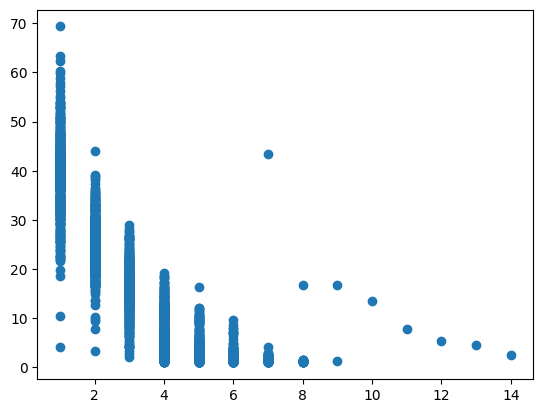

In [ ]:
#rey
xx = x4plot.iloc[:, 1]
yy = y4plot.iloc[:, 2]
plt.scatter(yy,xx)
#comparing each rank group

- การพล็อตกราฟเพื่อดูว่าแต่ล่ะอันดับที่ชนะในเขตนั้นมีแนวโน้มอย่างไร โดยจะเห็นว่าแต่ละอันดับมีความเกะกลุ่มกันอย่างเห็นได้ชัด และหลังจากอันดับที่ 7 ข้อมูลมีความกระจัดกระจายซึ่งเกิดจากการที่บางเขตมีพรรคที่เข้ามาแย่งชิงคะแนนเสียงน้อยกว่า 7 พรรค

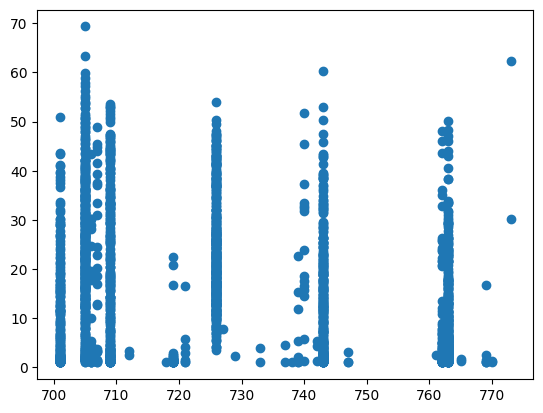

In [ ]:
xx = x4plot.iloc[:, 1]
yy = y4plot.iloc[:, 3]
plt.scatter(yy,xx)
#percent in each party

- กราฟเพื่อดูว่าแต่ละพรรคมีคนโหวตมากแค่ในแต่ละเขตและดูปริมาณของ data ในแต่ละพรรค ซึ่งจะเห็นว่าพรรคที่มีจุดเยอะคือพรรคที่เป็นพรรคใหญ่และบางพรรคที่ไม่มีคนโหวตเลย เพราะน่าจะเป็นพรรคเล็กหรือข้อมูลผิดพลาด

###**2. Data Preprocessing**

- ทำการแบ่งชุดข้อมูลสำหรับ Test เท่ากับ 25% และ Train เท่ากับ 75%

In [ ]:
#train and  test devide from data set
trainX,testX,trainY,testY = train_test_split(data_x, data_y, test_size = 0.25 , random_state = 42)

In [ ]:
print('Size of x training:',len(trainX))
print('Size of y training:',len(trainY))
print('Size of x testing:',len(testX))
print('Size of y testing:',len(testY))

Size of x training: 1632
Size of y training: 1632
Size of x testing: 545
Size of y testing: 545
Size of x testing: 1086
Size of y testing: 1091


###**3. Model Construction and Analysis**

###**Logistic regression Model:**
สมมติฐาน : ทำนายว่าเป็นพรรคการเมืองไหน จากจำนวนคะแนนเสียง ส.ส. เขตที่ได้ และ จำนวนร้อยละคะแนนเสียง ส.ส. เขตของพรรคนั้นต่อจำนวนผู้ใช้สิทธิ์ทั้งหมด

- ทำการเทรน Logistic linear regression โดยใช้ข้อมูล trainX และ trainY
- ให้โมเดลทำนายออกมาในรูปแบบธรรมดาและในรูปแบบความน่าจะเป็นของแต่ละตัว
- การที่โมเดลทำนายออกมาในรูปแบบ predict_proba นั้นจะแสดงให้เห็นถึงความน่าจะเป็นของแต่ละคำตอบจากมุมมองของโมเดล และแสดงถึงความมั่นใจในแต่ละคำตอบ

In [ ]:
#rey
#Build linear regression model
model_logistic = LogisticRegression(multi_class='multinomial', solver='lbfgs',C=1.0, max_iter=10000) #<------------logis
model_logistic.fit(trainX,trainY)  #<------------logis
y_pred_prob = model_logistic.predict_proba(testX) #<------------logis
y_pred_prob = y_pred_prob[0]
y_pred_norm = model_logistic.predict(testX)
print(y_pred_prob) #<------------logis

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[3.94572185e-02 3.59877512e-01 6.40781957e-04 1.66492950e-03
 1.72822648e-01 2.28394538e-26 4.55420035e-07 3.24167167e-11
 2.82297968e-01 8.13166513e-66 5.27880104e-34 4.11652996e-29
 1.44156748e-42 3.04248283e-46 4.56553383e-07 1.46862690e-03
 3.16986953e-40 8.13630402e-02 6.31353871e-51 5.48130223e-85
 8.69045453e-03 5.17062843e-02 1.16130828e-33 7.93379711e-40
 1.36705304e-43 9.62364858e-06]


In [ ]:
print(y_pred_norm)


[705 705 705 763 726 763 763 763 763 705 705 705 705 763 726 705 763 705
 763 726 763 726 705 726 763 763 705 726 705 705 726 763 763 763 763 763
 705 763 705 705 763 705 705 705 705 705 705 705 726 763 705 763 705 763
 705 763 763 726 705 763 763 705 726 705 726 705 763 705 763 705 705 726
 705 705 726 763 763 763 763 705 705 705 763 705 763 705 763 705 763 726
 763 705 763 705 763 705 705 726 763 705 763 726 705 763 726 705 705 705
 705 705 763 705 763 763 705 763 763 705 726 763 726 763 763 705 705 726
 763 763 705 705 763 705 705 763 705 763 763 705 705 763 763 726 740 705
 763 705 705 726 705 763 726 705 763 763 705 726 726 705 763 705 763 705
 726 763 705 763 763 705 705 763 763 726 705 763 705 705 763 705 705 705
 705 705 705 705 705 705 726 726 763 763 705 726 705 705 705 763 726 705
 763 705 763 705 763 705 705 763 705 763 705 763 705 705 763 705 763 763
 726 705 763 726 705 705 705 726 763 763 726 726 726 705 763 705 705 763
 705 763 763 763 705 705 763 763 763 705 705 763 70

โค้ดในส่วนนี้เป็นการแปลง dataframe เป็น numpy matrix เผื่อการนำไปคำนวณผลในอนาคต

In [ ]:
#rey
## Convert the DataFrame to a NumPy matrix
list1 = testY.values
list1a = list1.ravel()
list2b = y_pred_norm.tolist()
##turn in to set
set1 = set(list1a)
set2 = set(list2b)

นำเสนอผลลัพธ์ของโมเดลในรูปแบบ classification report เพื่อแสดงให้เห็นความแม่นยำของแต่ lebel และปริมาณของแต่ละ lebel และปริมาณของข้อมูลทั้งหมดที่ใช้เทียบกับผลลัพธ์

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

              precision    recall  f1-score   support

         701       0.00      0.00      0.00        52
         705       0.23      0.40      0.29       100
         706       0.00      0.00      0.00        10
         707       0.00      0.00      0.00         4
         709       0.00      0.00      0.00        65
         712       0.00      0.00      0.00         2
         718       0.00      0.00      0.00         1
         719       0.00      0.00      0.00        12
         721       0.00      0.00      0.00         2
         726       0.25      0.56      0.35        96
         727       0.00      0.00      0.00         1
         729       0.00      0.00      0.00         1
         739       0.00      0.00      0.00         2
         740       0.00      0.00      0.00         4
         743       0.00      0.00      0.00        77
         747       0.00      0.00      0.00         2
         761       0.00      0.00      0.00         1
         762       0.00    

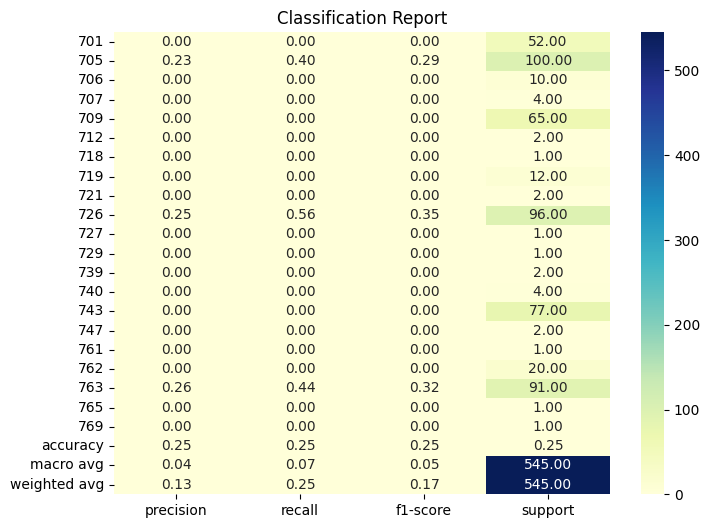

In [ ]:
from sklearn.metrics import classification_report
y_true = testY  # Replace with your true labels
y_pred = y_pred_norm  # Replace with your predicted labels
# Assuming you have already trained your multiclass logistic regression model
classification_rep = classification_report(y_true, y_pred)
print(classification_rep)
# Display the classification report as a heatmap
report_data = classification_report(y_true, y_pred, output_dict=True)
# Convert the dictionary to a DataFrame
report_df = pd.DataFrame(report_data)
# Transpose the DataFrame for better visualization
report_df = report_df.transpose()
# Display the classification report as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Classification Report')
plt.show()


สร้าง Confusion Matrix เพื่อนับความถูกต้องของแต่ละคลาส

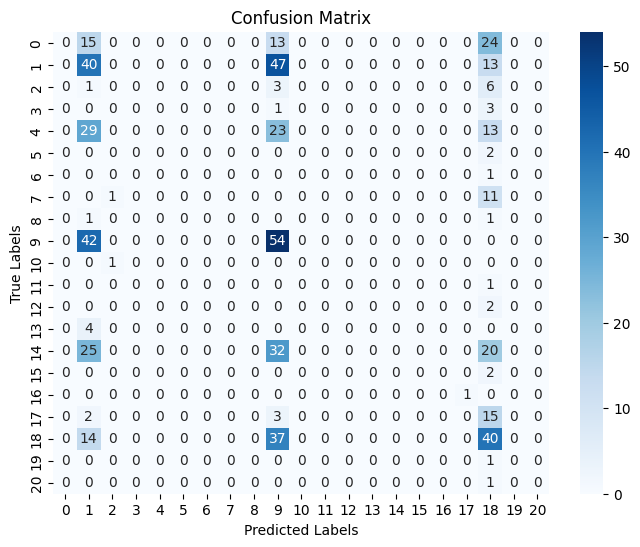

In [ ]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


###**สรุปผลการทดลอง**

จากการทดลองพบว่า
- พบว่ามีแค่ 3 พรรคจากทั้งหมดที่โมเดลสามารถทำนายได้และมีความถูกต้องอยู่ที่ประมาณ 25% สำหรับพรรคที่ทำนายได้ ส่วนความถูกต้องโดยรวมมีความแม่นยำอยู่ที่ 13%
- ทั้งสามพรรคที่ทำนายได้คือ พรรคเพื่อไทย พรรคกล้าวไกล และพรรครวมไทยสร้างชาติ โดยที่สาเหตุที่สามารถทำนายทั้ง 3 พรรคนี้ได้ คือ จำนวนผู้ที่มาลงคะแนนเสียงให้กับพรรคนั้นๆมีมากพอที่โมเดลสามารถทำนายการตัดสินใจได้